# Unit 3: House prices
###### Candelaria Retamal
###### **18.05.2022**

## Table of contents

<a id="Table"></a>
### [A. Data Cleaning](#Cleaning)

### [B. Feature Encoding](#Encoding)

### [C. Feature Engineering](#Engineering)

### [D. Splitting Data](#Splitting)

### [E. Model Fitting](#Fitting)

### [F. Evaluation metrics](#Metrics)

### [G. Regularization](#Regularization)

### [H. Communicating the Results](#Communicate)

### [I. Compute Predictions](#Compute)

### [J. Evaluate Predictions](#Evaluate)

<a id="Cleaning"></a>
### **A. Data Cleaning**

> Your analysis should include the necessary data cleaning steps. For instance:
    - Find and handle incorrect, missing values
    - Correct inconsistencies in the variables
    - Handle outliers -
    You are free to choose your preferred approach to handle each step. For instance, you might want to replace missing values with the average or the most frequent value or create an missing category. In any case, justify your choices!

We will first load the information, and start by taking a quick look to the level of completeness of the available data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.datasets import fetch_openml
from scipy import stats
from scipy.stats import norm, skew

%load_ext lab_black
%matplotlib inline

# Load the data into a Pandas DataFrame
df = pd.read_csv("house-prices.csv")
df.head(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


Now we will use some tools learned during the second unit for counting the amount of information that may be missing or incomplete in the original database. It is important to mention that the variables Order and PID will be eliminated, as they do not have information that may be useful for the price prediction. 

* We will first check the number of rows and columns in the original dataframe

In [2]:
# Number of rows
print(df.shape[0])
# Number of columns
print(df.shape[1])

2430
82


* We will now verify the amount of columns that contain each type of element

In [3]:
# Count how many times each data type is present in the dataset
pd.value_counts(df.dtypes)

object     43
int64      28
float64    11
dtype: int64

* Let's take a look at the data frame for visualizing the ocupation of the cells with information

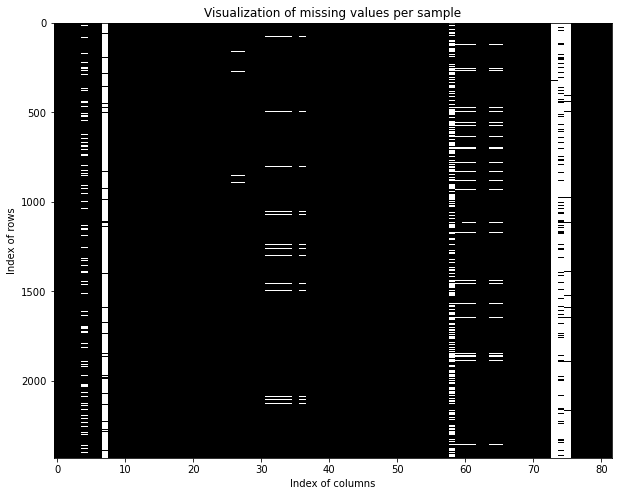

In [4]:
# This is a representation of the occupation of cells in the dataset.
plt.figure(figsize=(10, 8))
plt.title("Visualization of missing values per sample")
plt.xlabel("Index of columns")
plt.ylabel("Index of rows")
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")

* If we visualize the percentage of missing information per feature 

<AxesSubplot:title={'center':'Percentage of missing values per feature'}>

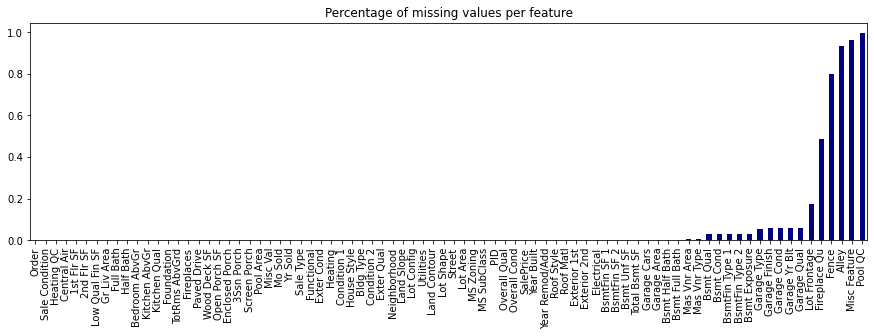

In [5]:
# If we check the % of missing information per feature
df.isna().mean().sort_values().plot(
    kind="bar",
    figsize=(15, 4),
    title="Percentage of missing values per feature",
    color="navy",
)

**Observations:** There are a small amount of features (only 5) that lack of more than a 40% of information. These entries will be checked in order to  see if there is any possibility of filling up the gaps. If this is not possible, this columns will be eliminated along with the Order and PID columns.

*  We will first check if there are any duplicated entries in the database

In [6]:
print("There are a total of " + str(df.duplicated().sum()) + " duplicated entries")

There are a total of 0 duplicated entries


* There are no duplicated values to eliminate, hence we will now check the variables that count with a unique value along the numeric and object type features. Unique value columns correspond to those features that contain a unique possibility for all of the rows.

In [7]:
# First we check the columns which dtype is numeric
unique_numeric = df.select_dtypes(include="number").nunique().sort_values()
np.sum(np.array(unique_numeric) == 1)

0

In [8]:
# Now we check the columns wich dtype is object
unique_obj = df.select_dtypes(include="object").nunique()
np.sum(np.array(unique_obj) == 2)
print(unique_obj == 2)

MS Zoning         False
Street             True
Alley              True
Lot Shape         False
Land Contour      False
Utilities         False
Lot Config        False
Land Slope        False
Neighborhood      False
Condition 1       False
Condition 2       False
Bldg Type         False
House Style       False
Roof Style        False
Roof Matl         False
Exterior 1st      False
Exterior 2nd      False
Mas Vnr Type      False
Exter Qual        False
Exter Cond        False
Foundation        False
Bsmt Qual         False
Bsmt Cond         False
Bsmt Exposure     False
BsmtFin Type 1    False
BsmtFin Type 2    False
Heating           False
Heating QC        False
Central Air        True
Electrical        False
Kitchen Qual      False
Functional        False
Fireplace Qu      False
Garage Type       False
Garage Finish     False
Garage Qual       False
Garage Cond       False
Paved Drive       False
Pool QC           False
Fence             False
Misc Feature      False
Sale Type       

**Observations:** The 2 columns of type object that are unique will be dropped, as they dont contribute in the decision making (for the house's values)

In [9]:
# We fill the NaN values of the columns saved in unique. For filling this columns, there is an only value that may be incorporated (as it was previously stated)
df.drop(["Central Air"], axis=1, inplace=True)
df.drop(["Street"], axis=1, inplace=True)

* We will only maintain those columns that count with more than a 40% of information. The rest of the columns will be dropped.

In [10]:
# We calculate the null percentage:
null_percentage = df.isnull().sum() / df.shape[0] * 100
# Drop columns with more than a 40% of missing values
for x in range(0, len(null_percentage)):
    if null_percentage[x] >= 40:
        print(df.index[x])
        df.drop([null_percentage.index[x]], axis=1, inplace=True)

6
56
71
72
73


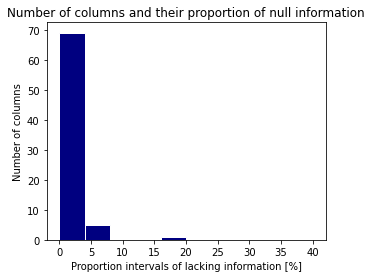

In [11]:
# % of null information in the columns
null_percentage = df.isnull().sum() / df.shape[0] * 100

hist = null_percentage.plot.hist(
    bins=10, color="navy", edgecolor="white", range=[0, 40], figsize=(5, 4)
)
hist.set_xlabel("Proportion intervals of lacking information [%]")
hist.set_ylabel("Number of columns")
hist.set_title("Number of columns and their proportion of null information")
plt.show()

In [12]:
df.drop("Order", inplace=True, axis=1)
# df.drop("PID", inplace=True, axis=1)

**Observations** After cleaning the data, the columns have between 0% and 5% of missing values. We consider that this amount of information is good enough for working with the database. As we mentioned before, we will also eliminated the columns that only identify the entries (Order and PID)

* We will now check the columns with missing data, for evaluating a possible strategy for filling the values

In [13]:
null_list = df.columns[df.isnull().any()].tolist()
df[null_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Frontage    2010 non-null   float64
 1   Mas Vnr Type    2410 non-null   object 
 2   Mas Vnr Area    2410 non-null   float64
 3   Bsmt Qual       2359 non-null   object 
 4   Bsmt Cond       2359 non-null   object 
 5   Bsmt Exposure   2356 non-null   object 
 6   BsmtFin Type 1  2359 non-null   object 
 7   BsmtFin SF 1    2429 non-null   float64
 8   BsmtFin Type 2  2358 non-null   object 
 9   BsmtFin SF 2    2429 non-null   float64
 10  Bsmt Unf SF     2429 non-null   float64
 11  Total Bsmt SF   2429 non-null   float64
 12  Electrical      2429 non-null   object 
 13  Bsmt Full Bath  2428 non-null   float64
 14  Bsmt Half Bath  2428 non-null   float64
 15  Garage Type     2294 non-null   object 
 16  Garage Yr Blt   2292 non-null   float64
 17  Garage Finish   2292 non-null   o

In [14]:
df[null_list].describe()

,Lot Frontage,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area
count,2010.000000,2410.000000,2429.000000,2429.000000,2429.000000,2429.000000,2428.000000,2428.000000,2292.000000,2429.000000,2429.000000
mean,69.201990,101.995436,443.944422,51.073693,556.480856,1051.498971,0.434102,0.060132,1977.861257,1.762454,471.979415
std,23.486988,176.611699,457.453649,172.143522,439.650118,444.690012,0.527941,0.242923,25.544869,0.758243,215.753523
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1896.000000,0.000000,0.000000
25%,58.000000,0.000000,0.000000,0.000000,216.000000,794.000000,0.000000,0.000000,1960.000000,1.000000,324.000000
50%,68.000000,0.000000,375.000000,0.000000,462.000000,990.000000,0.000000,0.000000,1978.000000,2.000000,478.000000
75%,80.000000,164.750000,737.000000,0.000000,799.000000,1299.000000,1.000000,0.000000,2002.000000,2.000000,576.000000
max,313.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,3.000000,2.000000,2207.000000,4.000000,1488.000000


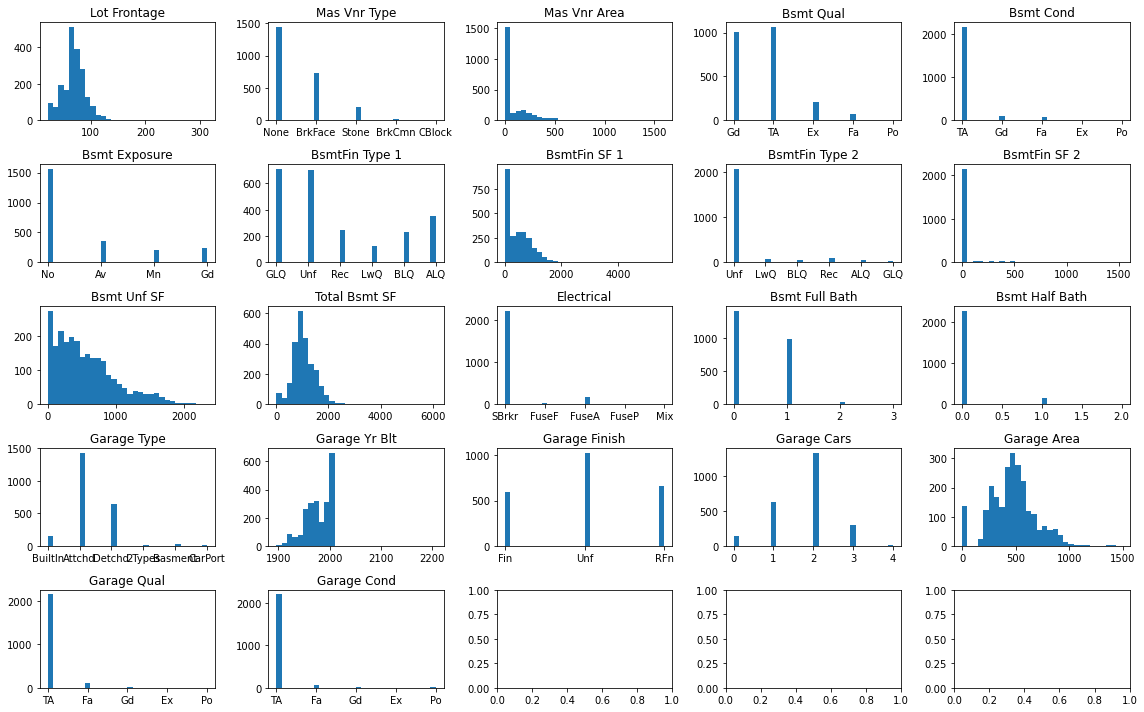

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,528275070,60,RL,NaN,8795,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2009,WD,Normal,236000
1,535305120,20,RL,75.0,10170,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,155000
2,923228250,160,RM,21.0,2001,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,1,2007,WD,Normal,75000
3,535152150,20,RL,70.0,10552,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2010,WD,Normal,165500
4,903475060,190,RM,60.0,10120,IR1,Bnk,AllPub,Inside,Gtl,...,264,0,0,0,0,1,2007,WD,Normal,122000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,904301070,90,RL,60.0,10800,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2009,WD,Alloca,179000
2426,907126010,20,RL,82.0,12464,IR2,Low,AllPub,Corner,Mod,...,0,0,0,0,0,11,2009,WD,Normal,152000
2427,527353080,60,RL,80.0,11584,Reg,Lvl,AllPub,Inside,Gtl,...,216,0,0,0,0,11,2007,WD,Normal,197000
2428,535402070,80,RL,85.0,13400,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,159950


In [15]:
# A quick look at the distribution of the variables
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 10))

for c, ax in zip(null_list, axes.ravel()):
    ax.hist(df[c].dropna(), bins=30)
    ax.set_title(c)

plt.tight_layout()  # to avoid overlapping with the labels
plt.show()
df

**Observations:** Through the plots of the numerical values contained among the null_list variables, we will take the following decisions: (1) The missing values in Lot Frontage will be replaced by the mean, because the data is only slightly skewed to the left. (2) For the variable Garage Yr Blt, the missing values will be replaced by the median because the data is extremely skewed to the right. (3) The missing values in Mas Vnr Area will be replaced with the median value because the data is extremely skewed to the left. 

The qualitative variables will be replaced differently: (1) Those features that present a clear predominant value will use this value for replacing its missing rows. (2) The rest of the features' missing values will be replaced by a new missing category.

In [16]:
# Replace numerical NaN values
# Mean replacements (near to normal distributions)
df["Lot Frontage"].fillna(int(df["Lot Frontage"].mean()), inplace=True)
df["Total Bsmt SF"].fillna(int(df["Total Bsmt SF"].mean()), inplace=True)
df["Garage Area"].fillna(int(df["Garage Area"].mean()), inplace=True)
# Median replacements (skewed distributions)
df["Garage Yr Blt"].fillna(int(df["Garage Yr Blt"].median()), inplace=True)
df["Mas Vnr Area"].fillna(int(df["Mas Vnr Area"].median()), inplace=True)
df["Bsmt Unf SF"].fillna(int(df["Bsmt Unf SF"].median()), inplace=True)
df["BsmtFin SF 1"].fillna(int(df["BsmtFin SF 1"].median()), inplace=True)
df["Bsmt Half Bath"].fillna(int(df["Bsmt Half Bath"].median()), inplace=True)
df["Bsmt Full Bath"].fillna(int(df["Bsmt Full Bath"].median()), inplace=True)
df["Garage Cars"].fillna(int(df["Garage Cars"].median()), inplace=True)
# Check the new list of missing values
null_list = df.columns[df.isnull().any()].tolist()
df[null_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Mas Vnr Type    2410 non-null   object 
 1   Bsmt Qual       2359 non-null   object 
 2   Bsmt Cond       2359 non-null   object 
 3   Bsmt Exposure   2356 non-null   object 
 4   BsmtFin Type 1  2359 non-null   object 
 5   BsmtFin Type 2  2358 non-null   object 
 6   BsmtFin SF 2    2429 non-null   float64
 7   Electrical      2429 non-null   object 
 8   Garage Type     2294 non-null   object 
 9   Garage Finish   2292 non-null   object 
 10  Garage Qual     2292 non-null   object 
 11  Garage Cond     2292 non-null   object 
dtypes: float64(1), object(11)
memory usage: 227.9+ KB


In [17]:
# Fill categorical features with a new missing category
df["Bsmt Qual"].fillna(("Missing"), inplace=True)
df["BsmtFin Type 1"].fillna(("Missing"), inplace=True)
df["Garage Finish"].fillna(("Missing"), inplace=True)
# Check the new list of missing values
null_list = df.columns[df.isnull().any()].tolist()
df[null_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Mas Vnr Type    2410 non-null   object 
 1   Bsmt Cond       2359 non-null   object 
 2   Bsmt Exposure   2356 non-null   object 
 3   BsmtFin Type 2  2358 non-null   object 
 4   BsmtFin SF 2    2429 non-null   float64
 5   Electrical      2429 non-null   object 
 6   Garage Type     2294 non-null   object 
 7   Garage Qual     2292 non-null   object 
 8   Garage Cond     2292 non-null   object 
dtypes: float64(1), object(8)
memory usage: 171.0+ KB


In [18]:
# Fill the rest of the categorical data with the most common value
df = df.fillna(df.mode().iloc[0])
# Check the new list of missing values
null_list = df.columns[df.isnull().any()].tolist()
df[null_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Empty DataFrame

In [19]:
# Number of rows
print(df.shape[0])
# Number of columns
print(df.shape[1])

2430
74


**Observations:** We may see that the number of rows is the same as the number of rows in the beggining (because no duplicated items were found). Through the cleaning process we have only dropped 9 columns (passing from 82 to 73). 

* The next step consists on looking for possible outliers. For this purpose we will first try to use an interquartile range approach

In [20]:
# We will extract the outliers, considering the interquartile range of the numeric values
Q1 = np.percentile(df.select_dtypes(include=np.number), 25, axis=0)
Q3 = np.percentile(df.select_dtypes(include=np.number), 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lets now print the values that are found outside the interquartile range for every numeric variable
boxplot_filter = (df.select_dtypes(include=np.number) < lower_bound) | (
    df.select_dtypes(include=np.number) > upper_bound
)

print("Number of outliers detected per feature using a boxplot:")
print(boxplot_filter.sum(axis=0))
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())

df_out = df.select_dtypes(include=np.number)[
    ~(
        (df.select_dtypes(include=np.number) < (Q1 - 1.5 * IQR))
        | (df.select_dtypes(include=np.number) > (Q3 + 1.5 * IQR))
    ).any(axis=1)
]

Number of outliers detected per feature using a boxplot:
PID                  0
MS SubClass        173
Lot Frontage       205
Lot Area           108
Overall Qual         4
Overall Cond       215
Year Built           6
Year Remod/Add       0
Mas Vnr Area       163
BsmtFin SF 1        12
BsmtFin SF 2       294
Bsmt Unf SF         45
Total Bsmt SF      108
1st Flr SF          36
2nd Flr SF           5
Low Qual Fin SF     30
Gr Liv Area         54
Bsmt Full Bath       2
Bsmt Half Bath     143
Full Bath            3
Half Bath            0
Bedroom AbvGr       61
Kitchen AbvGr      107
TotRms AbvGrd       36
Fireplaces          11
Garage Yr Blt        7
Garage Cars         12
Garage Area         36
Wood Deck SF        61
Open Porch SF      123
Enclosed Porch     375
3Ssn Porch          29
Screen Porch       218
Pool Area           12
Misc Val            88
Mo Sold              0
Yr Sold              0
SalePrice          110
dtype: int64
Total number of outliers detected: 2892


* As a final step, we will see what happens with the number of rows and columns if we dropped the rows using interquartiles

In [21]:
print(
    "The original shape of the DataFrame before selecting this outliers was "
    + str(df.shape)
)

print(
    "After eliminating the outliers through the interquartile strategy the new shape is "
    + str(df_out.shape)
)

The original shape of the DataFrame before selecting this outliers was (2430, 74)
After eliminating the outliers through the interquartile strategy the new shape is (909, 38)


**Observations** As the dimensions of the original dataframe have decresed in an extreme way, we will opt for making a manual filtering of those variables that are found to have the largest visible outliers. For this purpose we will start by plotting all of the numerical variables.

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

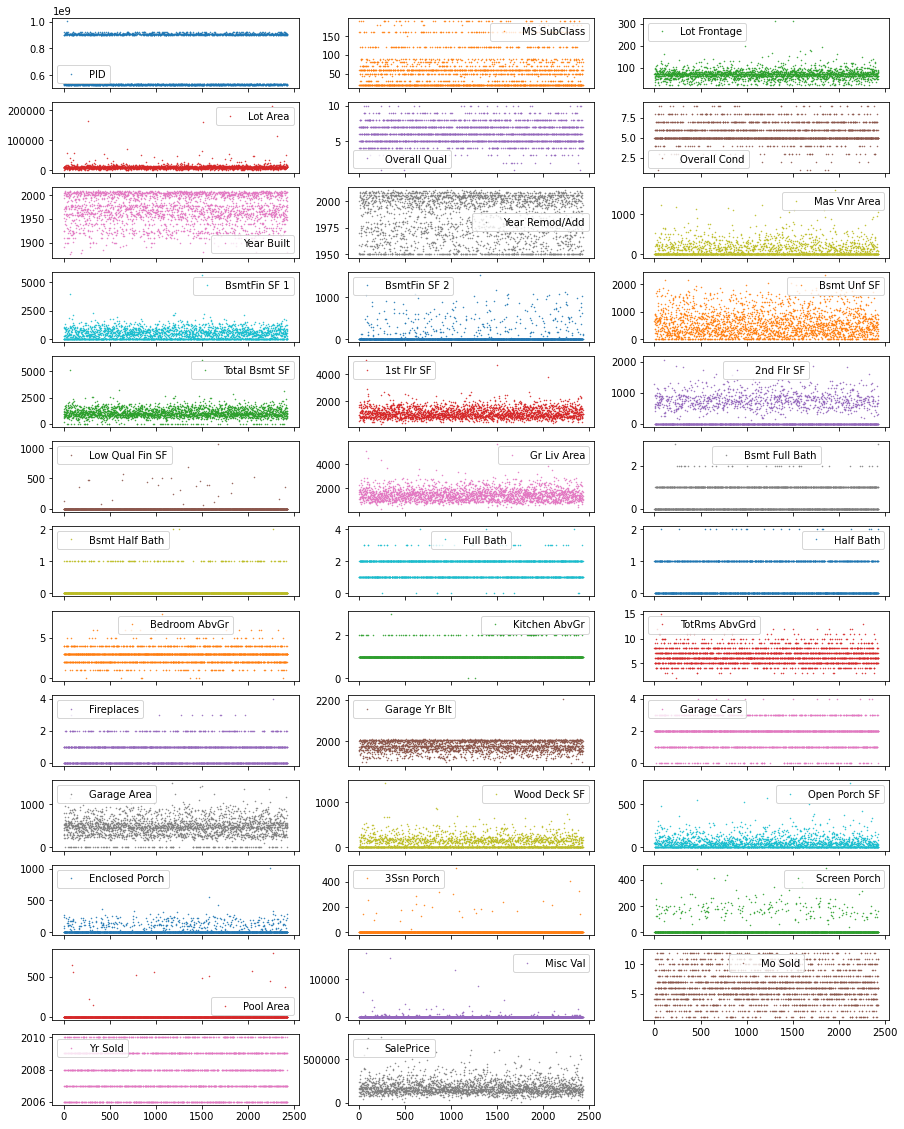

In [22]:
# Take a further look at possible outliers in the numeric category
df.select_dtypes(include=[np.number]).plot(
    lw=0, marker=".", subplots=True, layout=(-1, 3), figsize=(15, 20), markersize=1
)

In [23]:
# We will manually filter 8 variables

filter_outlier = df["Mas Vnr Area"] > 1000
df_keep = df.loc[filter_outlier, "Mas Vnr Area"]
df = df.drop(df_keep.index, axis=0)

filter_outlier = df["Lot Frontage"] > 200
df_keep = df.loc[filter_outlier, "Lot Frontage"]
df = df.drop(df_keep.index, axis=0)

filter_outlier = df["Low Qual Fin SF"] > 100
df_keep = df.loc[filter_outlier, "Low Qual Fin SF"]
df = df.drop(df_keep.index, axis=0)

filter_outlier = df["Pool Area"] > 500
df_keep = df.loc[filter_outlier, "Pool Area"]
df = df.drop(df_keep.index, axis=0)

filter_outlier = df["Garage Yr Blt"] < 1000
df_keep = df.loc[filter_outlier, "Garage Yr Blt"]
df = df.drop(df_keep.index, axis=0)

filter_outlier = df["Garage Yr Blt"] > 2022
df_keep = df.loc[filter_outlier, "Garage Yr Blt"]
df = df.drop(df_keep.index, axis=0)

filter_outlier = df["Misc Val"] > 1000
df_keep = df.loc[filter_outlier, "Misc Val"]
df = df.drop(df_keep.index, axis=0)


filter_outlier = df["BsmtFin SF 1"] > 2500
df_keep = df.loc[filter_outlier, "Misc Val"]
df = df.drop(df_keep.index, axis=0)

print(
    "After eliminating the outliers through manual filtering the new shape is "
    + str(df.shape)
)

After eliminating the outliers through manual filtering the new shape is (2359, 74)


**Observations** A manual filtering was applied for avoiding an intensive deletion of data. Through this approach the number of rows passed from 2430 to 2359.

* In the following steps we will transform every nominal variable into a non-numeric value (that will be hot encoded in the following section). For the ordinal features, we will transform all of them into numerical values, since these variables may be treated as any other numerical feature. Also, we will check that the ordinal and nominal variables present as many values as the documentation.txt mentions (for making sure that no mistaken values were unintentionally added in the model preparation). For this last point, we know that the variables Bsmt Qual, BsmtFin Type I and Garage Finish have one extra possible value that corresponds to missing.

In [24]:
nominal = []
ordinal = []
# check line by line in txt
with open("documentation.txt", "rt") as f:
    data = f.readlines()
# Generate two lists for Nominal and Ordinal variables
for line in data:
    if "(Nominal)" in line:
        nominal.append(line)

    if "(Ordinal)" in line:
        ordinal.append(line)

# Auxiliar variables for searching in the list of names
sub_str_nom = "(Nominal):"
sub_str_ord = "(Ordinal)"

# Remove after substring in String
nominal_var = []
ordinal_var = []
# slicing nominal variables names
for test_str in nominal:
    res = test_str[: test_str.index(sub_str_nom)][:-1]
    nominal_var.append(res)
# slicing ordinal variables names
for test_str in ordinal:
    res1 = test_str[: test_str.index(sub_str_ord)][:-1]
    ordinal_var.append(res1)

* As we are using the .txt document for separating ordinal and nominal variables we need to remove from the list those variables that were already removed from the database. Also, those variables that have a different name in the df v/s the .txt must be renamed for the correct categorization

In [25]:
# Remove variables that have been already dropped in the original d
nominal_var.remove("Alley")
nominal_var.remove("Misc Feature")
nominal_var.remove("Street")
nominal_var.remove("Central Air")

# Replace inexact names in .txt
nominal_var.remove("Exterior 1")
nominal_var.append("Exterior 1st")
nominal_var.remove("Exterior 2")
nominal_var.append("Exterior 2nd")

In [26]:
# Replace inexact names in .txt
ordinal_var.remove("BsmtFinType 2")
ordinal_var.append("BsmtFin Type 2")
ordinal_var.remove("HeatingQC")
ordinal_var.append("Heating QC")
ordinal_var.remove("KitchenQual")
ordinal_var.append("Kitchen Qual")
ordinal_var.remove("FireplaceQu")
# Remove variables that have been already dropped in the original df
ordinal_var.remove("Fence")
ordinal_var.remove("Pool QC")

In [27]:
print(df[nominal_var].nunique())
print(df[ordinal_var].nunique())

PID               2359
MS SubClass         15
MS Zoning            7
Land Contour         4
Lot Config           5
Neighborhood        28
Condition 1          9
Condition 2          7
Bldg Type            5
House Style          8
Roof Style           6
Roof Matl            6
Mas Vnr Type         5
Foundation           6
Heating              6
Garage Type          6
Sale Type           10
Sale Condition       6
Exterior 1st        16
Exterior 2nd        16
dtype: int64
Lot Shape          4
Utilities          3
Land Slope         3
Overall Qual      10
Overall Cond       9
Exter Qual         4
Exter Cond         5
Bsmt Qual          6
Bsmt Cond          5
Bsmt Exposure      4
BsmtFin Type 1     7
Electrical         5
Functional         8
Garage Finish      4
Garage Qual        5
Garage Cond        5
Paved Drive        3
BsmtFin Type 2     6
Heating QC         5
Kitchen Qual       5
dtype: int64


* With the segregation between ordinal and nominal, we now rename the ordinal values through a numerical scale. For this purpose the str values in the .txt document were checked for every ordinal variable and a categorization was proposed. The best values (in each ordinal scale) are related to higher numbers. Any NA value is related to number 0.

In [28]:
df[ordinal_var] = df[ordinal_var].replace(
    to_replace=["Reg", "IR1", "IR2", "IR3"], value=[4, 3, 2, 1]
)
df[ordinal_var] = df[ordinal_var].replace(
    to_replace=["AllPub", "NoSewr", "NoSeWa", "ELO"], value=[4, 3, 2, 1]
)
df[ordinal_var] = df[ordinal_var].replace(
    to_replace=["Gtl", "Mod", "Sev"], value=[3, 2, 1]
)

df[ordinal_var] = df[ordinal_var].replace(
    to_replace=["Ex", "Gd", "TA", "Fa", "Po", "NA"], value=[5, 4, 3, 2, 1, 0]
)
df[ordinal_var] = df[ordinal_var].replace(
    to_replace=["Av", "Mn", "No"], value=[3, 2, 1]
)
df[ordinal_var] = df[ordinal_var].replace(
    to_replace=["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf"], value=[6, 5, 4, 3, 2, 1]
)
df[ordinal_var] = df[ordinal_var].replace(
    to_replace=["SBrkr", "FuseA", "FuseF", "FuseP", "Mix"], value=[5, 4, 3, 2, 1]
)
df[ordinal_var] = df[ordinal_var].replace(
    to_replace=["Typ", "Min1", "Min2", "Mod", "Maj1", "Maj2", "Sev", "Sal"],
    value=[8, 7, 6, 5, 4, 3, 2, 1],
)

df[ordinal_var] = df[ordinal_var].replace(to_replace=["Fin", "RFn"], value=[3, 2])
df[ordinal_var] = df[ordinal_var].replace(to_replace=["Y", "P", "N"], value=[3, 2, 1])
df[ordinal_var] = df[ordinal_var].replace(
    to_replace=["GdPrv", "MnPrv", "GdWo", "MnWw"], value=[4, 3, 2, 1]
)
# Missing values are also replaced with 0
df[ordinal_var] = df[ordinal_var].replace(to_replace="Missing", value=0)
df[ordinal_var]

,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,Electrical,Functional,Garage Finish,Garage Qual,Garage Cond,Paved Drive,BsmtFin Type 2,Heating QC,Kitchen Qual
0,3,4,3,7,5,4,3,4,3,1,6,5,8,3,3,3,3,1,5,4
1,4,4,3,6,6,3,3,3,3,1,1,5,8,1,3,3,3,1,3,4
2,4,4,3,4,5,3,3,3,3,1,1,5,8,1,3,3,3,1,2,3
3,3,4,3,5,5,3,3,3,3,1,3,5,8,2,3,3,3,1,4,4
4,3,4,3,7,4,2,3,3,3,1,1,3,8,1,3,3,1,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,3,4,3,6,5,4,3,4,3,1,1,5,8,2,3,3,3,1,5,4
2425,4,4,3,5,5,3,4,4,4,4,6,5,8,0,3,3,3,1,3,3
2426,2,4,2,5,5,3,4,4,3,1,6,5,8,1,3,3,3,1,4,4
2427,4,4,3,7,6,3,3,3,3,1,6,5,8,2,3,3,3,3,3,3


**Observations:** Through this section we have transformed the ordinal variables to numeric values. This will make modeling easier as we will reduce the number of encoded variables.

* We will now check the original df, for making sure that the changes were correctly incorporated.

In [29]:
df

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,528275070,60,RL,69.0,8795,3,Lvl,4,Inside,3,...,0,0,0,0,0,4,2009,WD,Normal,236000
1,535305120,20,RL,75.0,10170,4,Lvl,4,Corner,3,...,0,0,0,0,0,6,2006,WD,Normal,155000
2,923228250,160,RM,21.0,2001,4,Lvl,4,Inside,3,...,0,0,0,0,0,1,2007,WD,Normal,75000
3,535152150,20,RL,70.0,10552,3,Lvl,4,Inside,3,...,0,0,0,0,0,4,2010,WD,Normal,165500
4,903475060,190,RM,60.0,10120,3,Bnk,4,Inside,3,...,264,0,0,0,0,1,2007,WD,Normal,122000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,528221030,60,RL,62.0,8857,3,Lvl,4,Inside,3,...,0,0,0,0,0,3,2007,New,Partial,171925
2425,904301070,90,RL,60.0,10800,4,Lvl,4,Inside,3,...,0,0,0,0,0,3,2009,WD,Alloca,179000
2426,907126010,20,RL,82.0,12464,2,Low,4,Corner,2,...,0,0,0,0,0,11,2009,WD,Normal,152000
2427,527353080,60,RL,80.0,11584,4,Lvl,4,Inside,3,...,216,0,0,0,0,11,2007,WD,Normal,197000


* The final step in the data cleaning section is to make sure that all of the nominal variables are non-numeric. For this we will check the type of the variables contained in the nominal list. We expect all of them to be of the type object.

In [30]:
pd.value_counts(df[nominal_var].dtypes)

object    18
int64      2
dtype: int64

In [31]:
# We finally change MS SubClass (the numeric variable) to a non numerical version for the hot-encoding.
df["MS SubClass"] = df["MS SubClass"].map(str)
pd.value_counts(df[nominal_var].dtypes)

object    19
int64      1
dtype: int64

**Observations** Now that the ordinal and nominal variables have been succesfully segregated (as numeric and non-numeric respectively), we will create a variable that contains the numerical features and a different variable that contains qualitative features. This will help to organize the features that will participate in the modeling process.

In [32]:
quantitative = [v for v in df.columns if df.dtypes[v] != "object"]
qualitative = [v for v in df.columns if df.dtypes[v] == "object"]

##### [Return to the table of contents](#Table)

<a id="Encoding"></a>
### **B. Variable Encoding**

For taking into consideration the consistency of the variables we will now use hot-encoding for turning the nominal variables into dummy variables. By this means we will ensure that the nominal variables will be useful at the moment of using the model for prediction.

**Solution:** Before starting with the solution of the problem, we will include a short summary (that comes from the documentation.txt).

* MS SubClass (Nominal): Identifies the type of dwelling involved in the sale [16 options]
* MS Zoning (Nominal): Identifies the general zoning classification of the sale [8 options]
* Street (Nominal): Type of road access to property [2 options]
* Alley (Nominal): Type of alley access to property [3 options]
* Land Contour (Nominal): Flatness of the property [4 options]
* Lot Config (Nominal): Lot configuration [5 options]
* Neighborhood (Nominal): Physical locations within Ames city limits (map available)[28 options]
* Condition 1 (Nominal): Proximity to various conditions [9 options]
* Condition 2 (Nominal): Proximity to various conditions (if more than one is present) [9 options]
* Bldg Type (Nominal): Type of dwelling [5 options]
* House Style (Nominal): Style of dwelling [8 options]
* Roof Style (Nominal): Type of roof [6 options]
* Roof Matl (Nominal): Roof material [8 options]
* Exterior 1 (Nominal): Exterior covering on house [17 options]
* Exterior 2 (Nominal): Exterior covering on house (if more than one material) [17 options]
* Mas Vnr Type (Nominal): Masonry veneer type [5 options]
* Foundation (Nominal): Type of foundation [6 options]
* Heating (Nominal): Type of heating [6 options]
* Central Air (Nominal): Central air conditioning [2 options]
* Garage Type (Nominal): Garage location [7 options]
* Misc Feature (Nominal): Miscellaneous feature not covered in other categories [6 options]
* Sale Type (Nominal): Type of sale [10 options]
* Sale Condition (Nominal): Condition of sale [6 options]


In [33]:
print(df[nominal_var].nunique())

PID               2359
MS SubClass         15
MS Zoning            7
Land Contour         4
Lot Config           5
Neighborhood        28
Condition 1          9
Condition 2          7
Bldg Type            5
House Style          8
Roof Style           6
Roof Matl            6
Mas Vnr Type         5
Foundation           6
Heating              6
Garage Type          6
Sale Type           10
Sale Condition       6
Exterior 1st        16
Exterior 2nd        16
dtype: int64


* The number of unique values in the columns does not surpass the number of options given in the .txt per nominal variable. For this reason we will assume that the nominal variables dont have typing errors, and we will proceed to fo the hot encoding.

**Observations** Through this section we have not yet hot-encoded the qualitative variables (that correspond to nominal variables). We will do this procedure in a further step located in the next section. Please pay special attention to the preprocess function

##### [Return to the table of contents](#Table)

<a id="Engineering"></a>
### **C. Feature Engineering**

* Since the variable that we need to predict corresponds to the Sales Price, we will start our analysis by checking it. In this step we will analyze the distribution of the variable to see if it is near to normality or if the variable could be transformed.

Text(0.5, 1.0, 'Sale Price')

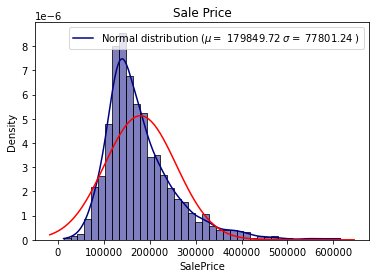

In [34]:
from scipy import stats
from scipy.stats import norm, skew

sns.set_color_codes()


ax = sns.histplot(df["SalePrice"], bins=40, stat="density", color="navy", kde=True)
mu, std = stats.norm.fit(df["SalePrice"])
normal_dist = np.linspace(*ax.get_xlim(), 100)
ax.plot(normal_dist, stats.norm.pdf(normal_dist, mu, std), color="red")
ax.legend(
    ["Normal distribution ($\mu=$ {:.2f} $\sigma=$ {:.2f} )".format(mu, std)],
    loc="best",
)
ax.set_title("Sale Price")

We can see that the distribution is skewed to the right. Hence, a good option is to apply a logarithmic transformation to the data. But first, we will see the correlation of the original Sale Price with the rest of the numeric variables.

<AxesSubplot:>

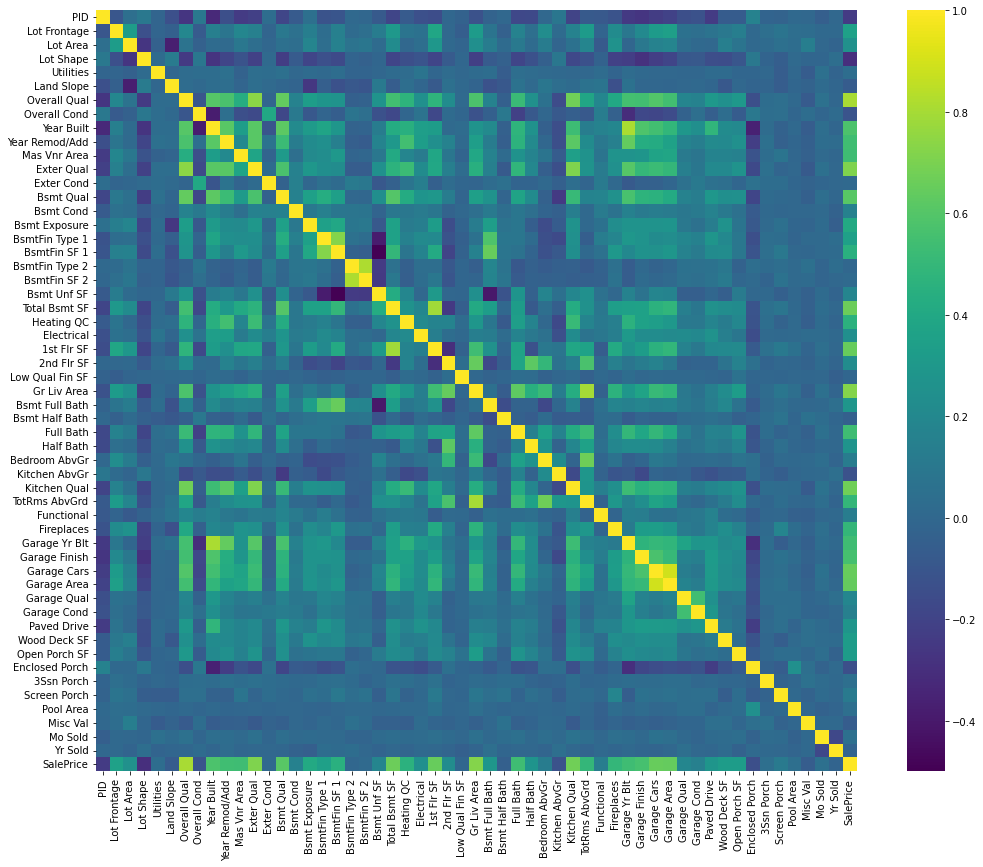

In [35]:
# Correlation map to see how features are correlated with SalePrice
corrmat = df.corr()
plt.subplots(figsize=(18, 14))
sns.heatmap(corrmat, vmin=-0.5, vmax=1, square=True, cmap="viridis")

**Observations:** The variables that show the highest correlation with the SalePrice are: Overall Qual, Year Built, Year Remod, Exter Qual, Bsmt Qual, Total Bsmt SF, 1st Flr SF, Gr Liv Area, Kitchen Qual, Garage Yr Blt, Garage Finish, Garage Cars, Garage Area. It is interesting to notice that the set of variables related to the squared meters, and the variables related to the garage and show a strong correlation with the Sale Price variable.

* Let's take a further look at those variables that have a correlation higher than 0.55 with the target variable

In [36]:
# Correlation with output variable
cor = df.corr()
cor_target = abs(cor["SalePrice"])
# Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.55]
features_list = relevant_features.index

<AxesSubplot:>

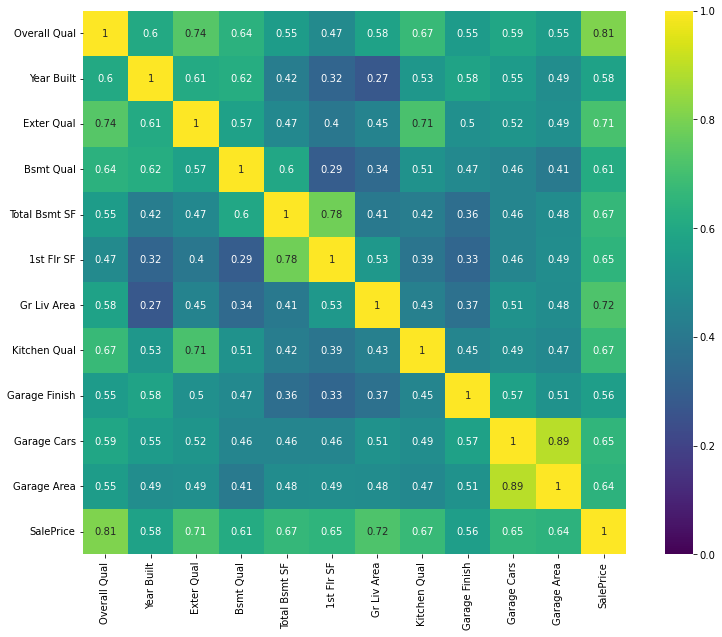

In [37]:
# Correlation map to see how features are correlated with SalePrice
corrmat = df[features_list].corr()
plt.subplots(figsize=(14, 10))
sns.heatmap(corrmat, vmin=0, vmax=1, square=True, cmap="viridis", annot=True)

**Observations:** For the following step we will take a look at the variables that present the highest correlation with the SalePrice. Each decision will be described in the next lines:

* The variable Overall Qual, is the one that presents the highest correlation. We will keep this feature, and eliminate the variable Exter Qual that is too closely correlated to Overall Qual (0.74).
* Total Bsmt SF and 1st Floor SF are highly correlated (0.78) as they correspond to the number of Square Feet in the Basement and 1st floor. Yet, not all of the houses count with a basement. For this reason we will delete the variable Total Bsmt SF and just create an auxiliar variable that has 0 if there is no basement and 1 if there is a basement. We will keep the variable 1st Flr SF.
* All of the remaining variables can be maintained as they don't show high correlation with others.

* In the following step we will chek the correleograms of the numeric variables that have been found as highly correlated, considering that some features should be dropped due to their high correlation with others (as it was previously mentioned in the points).

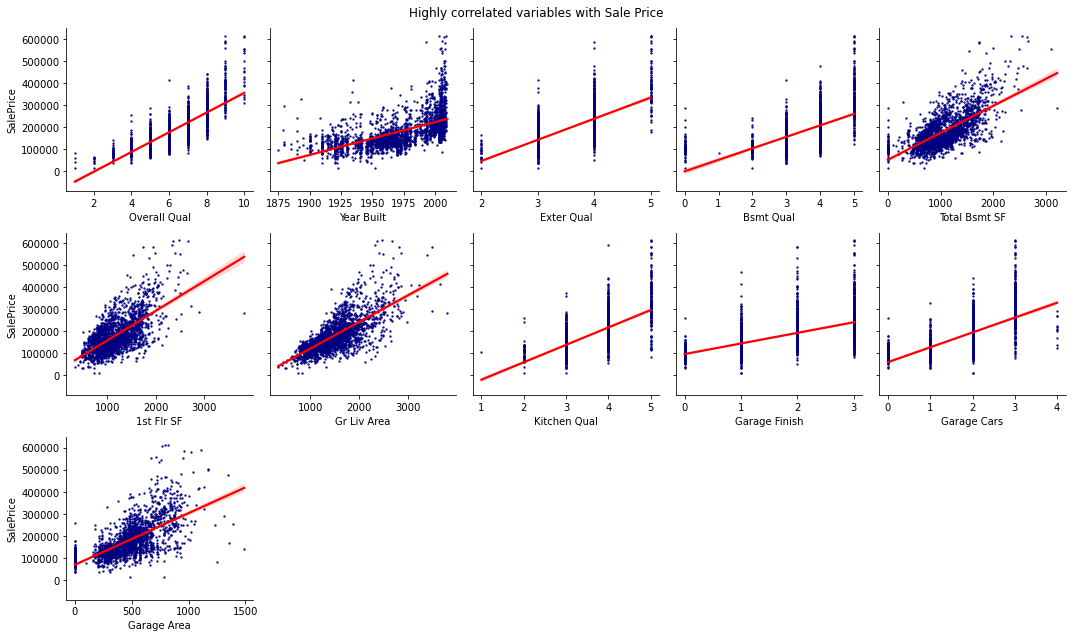

In [38]:
# Basic correlograms
cols = [
    "Overall Qual",
    "Year Built",
    "Exter Qual",
    "Bsmt Qual",
    "Total Bsmt SF",
    "1st Flr SF",
    "Gr Liv Area",
    "Kitchen Qual",
    "Garage Finish",
    "Garage Cars",
    "Garage Area",
]

g = sns.FacetGrid(pd.DataFrame(cols), col=0, col_wrap=5, sharex=False)
for ax, xvar in zip(g.axes, cols):
    sns.regplot(
        data=df,
        x=xvar,
        y="SalePrice",
        ax=ax,
        marker="o",
        color="navy",
        scatter_kws={"s": 2},
        line_kws={"color": "red"},
    )
g.fig.suptitle("Highly correlated variables with Sale Price")
g.tight_layout()

**Observations:** We may see that the variables that present a high correlation with Sale Price are in most of the cases positively correlated with the target variable. But, the SalePrice variable presented a skwed behaviour. Do the results change if we transfrom the target variable?

* We will now transform the Sale Price (using a log transfromation). For this we will create ena alternative auxiliar variable. Afterwards we will re check the relationship within the quantitative variables

In [39]:
df

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,528275070,60,RL,69.0,8795,3,Lvl,4,Inside,3,...,0,0,0,0,0,4,2009,WD,Normal,236000
1,535305120,20,RL,75.0,10170,4,Lvl,4,Corner,3,...,0,0,0,0,0,6,2006,WD,Normal,155000
2,923228250,160,RM,21.0,2001,4,Lvl,4,Inside,3,...,0,0,0,0,0,1,2007,WD,Normal,75000
3,535152150,20,RL,70.0,10552,3,Lvl,4,Inside,3,...,0,0,0,0,0,4,2010,WD,Normal,165500
4,903475060,190,RM,60.0,10120,3,Bnk,4,Inside,3,...,264,0,0,0,0,1,2007,WD,Normal,122000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,528221030,60,RL,62.0,8857,3,Lvl,4,Inside,3,...,0,0,0,0,0,3,2007,New,Partial,171925
2425,904301070,90,RL,60.0,10800,4,Lvl,4,Inside,3,...,0,0,0,0,0,3,2009,WD,Alloca,179000
2426,907126010,20,RL,82.0,12464,2,Low,4,Corner,2,...,0,0,0,0,0,11,2009,WD,Normal,152000
2427,527353080,60,RL,80.0,11584,4,Lvl,4,Inside,3,...,216,0,0,0,0,11,2007,WD,Normal,197000


In [40]:
df["aux"] = np.log(df["SalePrice"])

With the transformation the data has approached better to normality and the skewness has been also corrected. Hence, we will maintain the logarithmic transformation for the following steps of feature engineering. Let's check the correleograms considering the transformation of the SalePrice variable.

<AxesSubplot:>

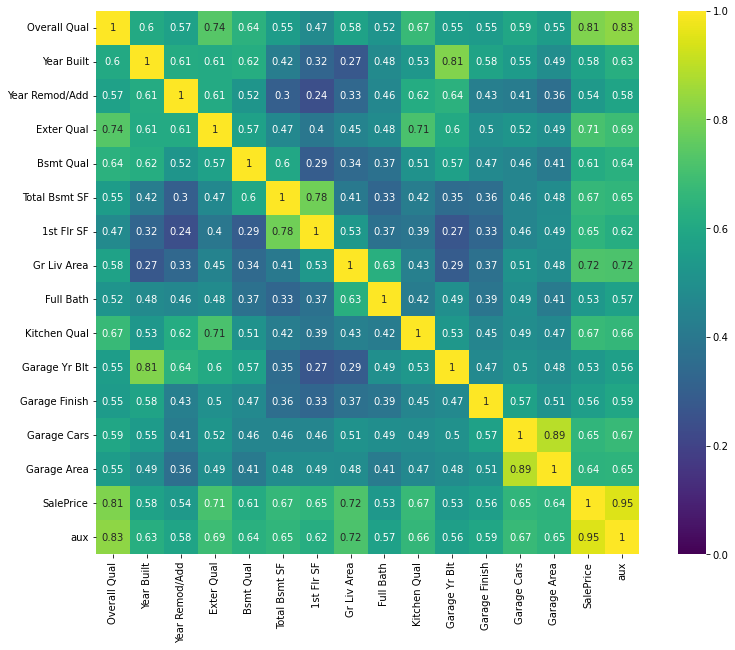

In [41]:
# Correlation with output variable
cor = df.corr()
cor_target = abs(cor["aux"])
# Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.55]
features_list = relevant_features.index
# Correlation map to see how features are correlated with SalePrice
corrmat = df[features_list].corr()
plt.subplots(figsize=(14, 10))
sns.heatmap(corrmat, vmin=0, vmax=1, square=True, cmap="viridis", annot=True)

With the log-transformation of the SalePrive variable, there are three new highly correlated variables with the target: Year Remod/Add (0.58), Full Bath (0.57) and Garage Yr Blt (0.56). 
* The feature Year Remod/Add will be maintained.
* Garage Yr Blt (0.56) will be dropped because it is highly related to Year Built (0.63).
* Additionally, we will drop Garage Area (0.65) as the number of cars that fit in a Garage (Garage Cars (0.67)) is clearly correlated with the area, but the number of cars is more correlated with the target variable.

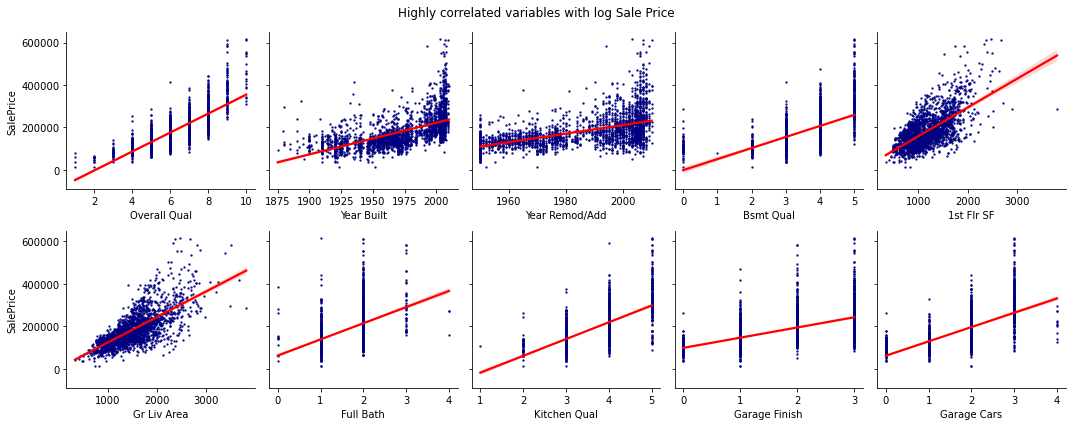

In [42]:
# Basic correlograms
features = [
    "Overall Qual",
    "Year Built",
    "Year Remod/Add",
    "Bsmt Qual",
    "1st Flr SF",
    "Gr Liv Area",
    "Full Bath",
    "Kitchen Qual",
    "Garage Finish",
    "Garage Cars",
]
g = sns.FacetGrid(pd.DataFrame(features), col=0, col_wrap=5, sharex=False)
for ax, xvar in zip(g.axes, features):
    sns.regplot(
        data=df,
        x=xvar,
        y="SalePrice",
        ax=ax,
        marker="o",
        color="navy",
        scatter_kws={"s": 2},
        line_kws={"color": "red"},
    )
g.fig.suptitle("Highly correlated variables with log Sale Price")
g.tight_layout()

**Observations:** By applying a log transfromation to the target variable, we may see that new relationships can be found. On the other hand, the correlation maps also show a better behaviour. In the following sections we will transform the most relevant numeric variables, and create new features based on the correleograms and the obtained results.

* We will start by creating boolean variables for those quantitative features that contain a 0 value that means that the house does not count with this facility. For doing this we will start by checking the numerical features that have 0 values within the options

In [43]:
(df[quantitative] == 0).sum() > 0

PID                False
Lot Frontage       False
Lot Area           False
Lot Shape          False
Utilities          False
Land Slope         False
Overall Qual       False
Overall Cond       False
Year Built         False
Year Remod/Add     False
Mas Vnr Area        True
Exter Qual         False
Exter Cond         False
Bsmt Qual           True
Bsmt Cond          False
Bsmt Exposure      False
BsmtFin Type 1      True
BsmtFin SF 1        True
BsmtFin Type 2     False
BsmtFin SF 2        True
Bsmt Unf SF         True
Total Bsmt SF       True
Heating QC         False
Electrical         False
1st Flr SF         False
2nd Flr SF          True
Low Qual Fin SF     True
Gr Liv Area        False
Bsmt Full Bath      True
Bsmt Half Bath      True
Full Bath           True
Half Bath           True
Bedroom AbvGr       True
Kitchen AbvGr       True
Kitchen Qual       False
TotRms AbvGrd      False
Functional         False
Fireplaces          True
Garage Yr Blt      False
Garage Finish       True


* From this analysis we will create boolean variables for Mas Vnr, Basement, 2nd Floor, Garage, Wood Deck and Porch

In [44]:
df["Has Mas Vnr"] = df["Mas Vnr Area"].apply(lambda x: 1 if x > 0 else 0)
df["Has Basement"] = df["Total Bsmt SF"].apply(lambda x: 1 if x > 0 else 0)
df["Has 2ndFloor"] = df["2nd Flr SF"].apply(lambda x: 1 if x > 0 else 0)
df["Has Garage"] = df["Garage Area"].apply(lambda x: 1 if x > 0 else 0)
df["Has WoodDeck"] = df["Wood Deck SF"].apply(lambda x: 1 if x > 0 else 0)
df["Has Porch"] = df["Open Porch SF"].apply(lambda x: 1 if x > 0 else 0)

We will continue the feature engineering by creating the variables that were mentioned in the correlation analysis:
* Total Bsmt SF and 1st Floor SF are highly correlated (0.78) as they correspond to the number of Square Feet in the Basement and 1st floor. Yet, not all of the houses count with a basement. For this reason we will delete the variable Total Bsmt SF and just maintain the boolean variable "Has Bsmt" that we created in the previous step

In [45]:
# df.drop("Total Bsmt SF", inplace=True, axis=1)

* Eliminate the variable Exter Qual due to its high correlation with Overall Qual

In [46]:
# df.drop("Exter Qual", inplace=True, axis=1)

* Garage Yr Blt (0.56) will be dropped because it is highly related to Year Built (0.63).

In [47]:
# df.drop("Garage Yr Blt", inplace=True, axis=1)

* Additionally, we will drop Garage Area (0.65) as the number of cars that fit in a Garage (Garage Cars (0.67)) is clearly correlated with the area, but the number of cars is more correlated with the target variable.

In [48]:
# df.drop("Garage Area", inplace=True, axis=1)

* The feature New will be created for indicating if the house was new at the moment it was sold.

In [49]:
df["New"] = np.where(df["Yr Sold"] == df["Year Built"], 1, 0)

* We will create one additional variable that contains the total number of baths (considering half bathrooms and complete ones)

In [50]:
df["Bath"] = (
    df["Full Bath"]
    + (0.5 * df["Half Bath"])
    + df["Bsmt Full Bath"]
    + (0.5 * df["Bsmt Half Bath"])
)

df.drop("Full Bath", inplace=True, axis=1)
df.drop("Half Bath", inplace=True, axis=1)
df.drop("Bsmt Full Bath", inplace=True, axis=1)
df.drop("Bsmt Half Bath", inplace=True, axis=1)

* We will drop the auxiliar variable that we created for looking at highky related variables

In [51]:
df.drop("aux", inplace=True, axis=1)

**Observations:** The variables that had been considered to be dropped due to high correlation ended up making the projections of the complex model worse when dropped. Hence, it was decided to maintain these variables afer the model fitting section and regularization was made.

* Let us take a further look at all of the remaining numerical variables. Is there any transformation that could be applied? We will pay special attention to the continous variables that can be found in the DF.

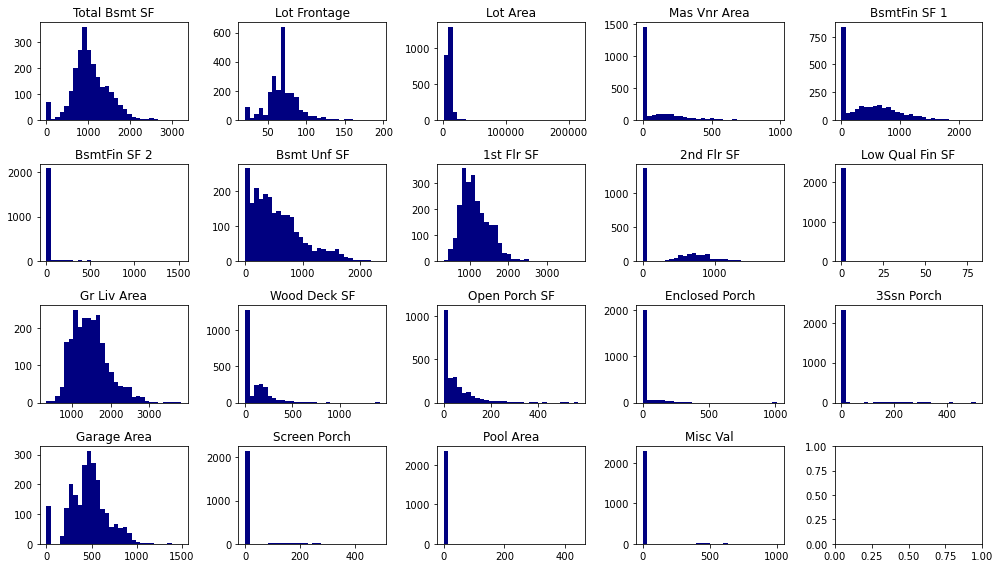

In [52]:
continuous = [
    "Total Bsmt SF",
    "Lot Frontage",
    "Lot Area",
    "Mas Vnr Area",
    "BsmtFin SF 1",
    "BsmtFin SF 2",
    "Bsmt Unf SF",
    "1st Flr SF",
    "2nd Flr SF",
    "Low Qual Fin SF",
    "Gr Liv Area",
    "Wood Deck SF",
    "Open Porch SF",
    "Enclosed Porch",
    "3Ssn Porch",
    "Garage Area",
    "Screen Porch",
    "Pool Area",
    "Misc Val",
]
# A quick look at the distribution of the variables
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(14, 8))

for c, ax in zip(continuous, axes.ravel()):
    ax.hist(df[c].dropna(), bins=30, color="navy")
    ax.set_title(c)

plt.tight_layout()  # to avoid overlapping with the labels
plt.show()

**Observations:** For preparing our DF for the modeling section we will incorporate a function that preprocesses the data (applying a log transformation and polynomial features to the quantitative continous variables that showed in most of the cases a high skweness. We will also apply polynomial transformations in the continous variables, and the **hot-encoded variables will be added to the original dataframe (df).

In [53]:
import numpy as np

# Preprocessing function
def preprocess(df):
    # Work on a copy
    df = df.copy()

    #  One-hot encoding
    df = pd.get_dummies(df, dummy_na=True)

    #  Apply log-transform
    df[continuous] = np.log1p(df[continuous])

    # Add polynomial features
    for c in continuous:
        for d in [0.5, 2, 3]:
            name = "{}**{}".format(c, d)
            df[name] = df[c] ** d

    return df


preprocessed_df = preprocess(df)
preprocessed_df.head()

,PID,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,...,Garage Area**3,Screen Porch**0.5,Screen Porch**2,Screen Porch**3,Pool Area**0.5,Pool Area**2,Pool Area**3,Misc Val**0.5,Misc Val**2,Misc Val**3
0,528275070,4.248495,9.082052,3,4,3,7,5,2000,2000,...,252.312340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,535305120,4.330733,9.227296,4,4,3,6,6,1951,1951,...,215.348490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,923228250,3.091042,7.601902,4,4,3,4,5,1970,1970,...,181.271738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,535152150,4.262680,9.264165,3,4,3,5,5,1959,1959,...,227.516489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,903475060,4.110874,9.222368,3,4,3,7,4,1910,1950,...,188.461820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Observations** As a last step in this part of the analysis, lets check the qualitative information. For starting we will take a look at the distribution of the target variable with qualitative values

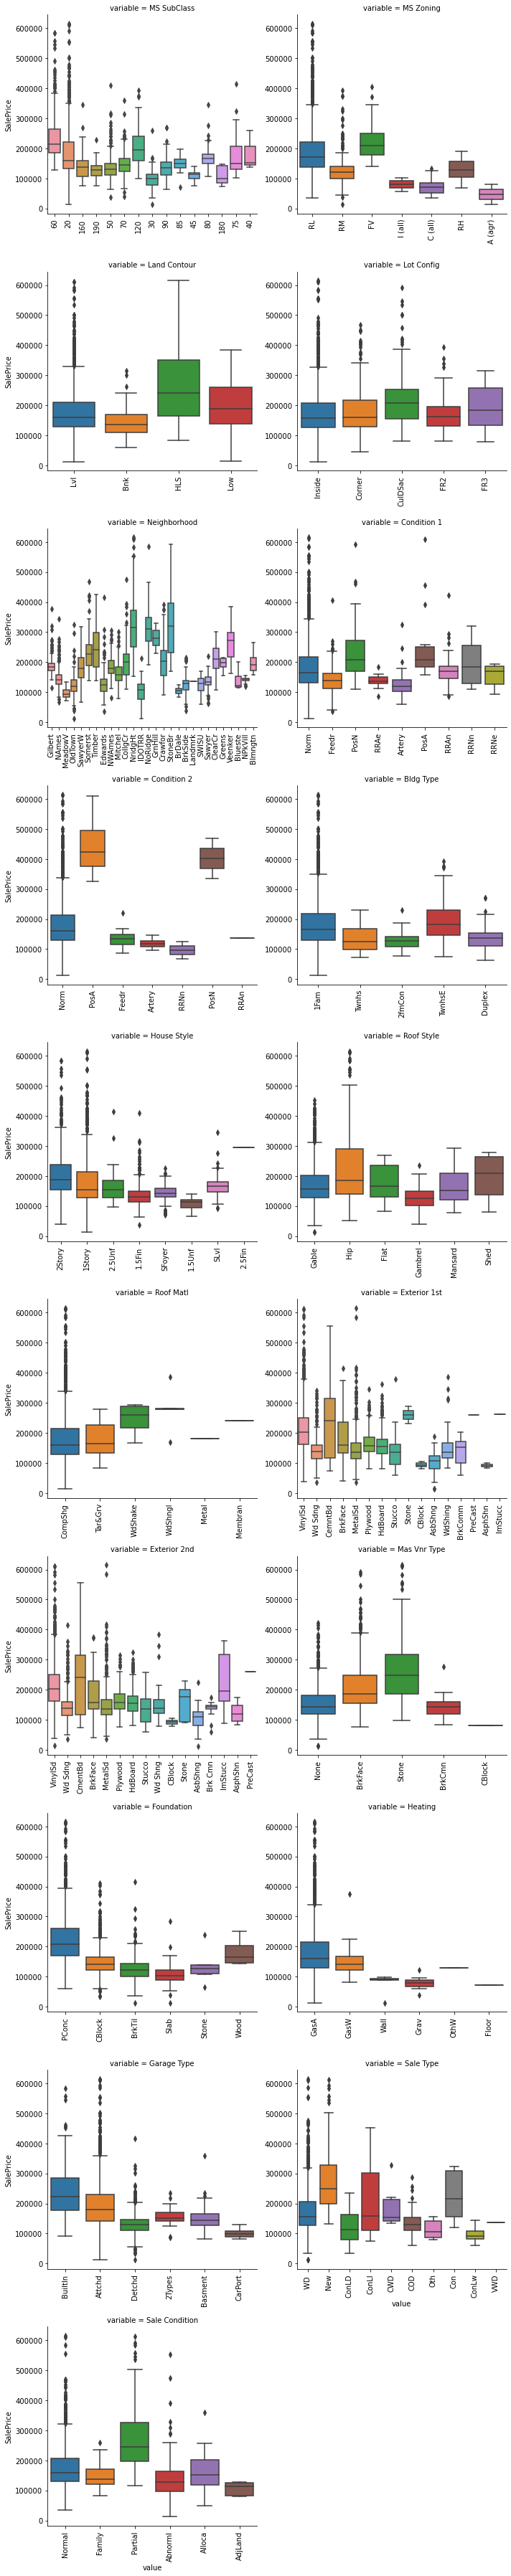

In [54]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)


f = pd.melt(df, id_vars=["SalePrice"], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "SalePrice")

**Observations:** By taking a look at the boxplots we may see that the Neighborhood variable could probably be relevant in terms of influencing the Sale Price.

##### [Return to the table of contents](#Table)

<a id="Splitting"></a>
### **D. Data Splitting**

In [55]:
# order columns alphabetically
preprocessed_df = preprocessed_df.reindex(sorted(preprocessed_df.columns), axis=1)
col_name = "Overall Qual"
# find the index no
index_no = preprocessed_df.columns.get_loc(col_name)

In [56]:
# (D) Create X, y
X = preprocessed_df.drop("SalePrice", axis=1).values
y = np.log10(preprocessed_df.SalePrice).values
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create X, y
simple = ["Overall Qual", "Gr Liv Area"]
X_simple = preprocessed_df[simple].values
medium = [
    "Overall Qual",
    "Year Built",
    "Year Remod/Add",
    "Bsmt Qual",
    "1st Flr SF",
    "Gr Liv Area",
    "Kitchen Qual",
    "Garage Finish",
    "Garage Cars",
    "Total Bsmt SF",
    "Exter Qual",
    "Garage Yr Blt",
    "Garage Area",
]
X_medium = preprocessed_df[medium].values

# Split into train/test sets
X_tr_s, X_te_s, y_tr_s, y_te_s = train_test_split(
    X_simple, y, test_size=0.4, random_state=0
)
# Split into train/test sets
X_tr_m, X_te_m, y_tr_m, y_te_m = train_test_split(
    X_medium, y, test_size=0.4, random_state=0
)
# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.4, random_state=0)

# Standardize features
scaler_simple = StandardScaler()
X_tr_s_rescaled = scaler_simple.fit_transform(X_tr_s)
X_te_s_rescaled = scaler_simple.transform(X_te_s)

# Standardize features
scaler_med = StandardScaler()
X_tr_m_rescaled = scaler_med.fit_transform(X_tr_m)
X_te_m_rescaled = scaler_med.transform(X_te_m)

# Standardize features
scaler = StandardScaler()
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

**Observations:** The data has been succesfully splitted, transformed and fitted for the model fitting upcoming section

##### [Return to the table of contents](#Table)

<a id="Fitting"></a>
### **E. Model Fitting**

**E1. Baseline**

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import Ridge

In [58]:
# Implement RMSE
def RMSE(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))


# Mean absolute error (MAE)
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [59]:
median_predictions = np.full_like(y_te, np.median(y_tr))
mae_baseline = MAE(10 ** y_te, 10 ** median_predictions)
rmse_baseline = RMSE(y_te, median_predictions)
print("MAE baseline: ${:.2f}".format(mae_baseline))

MAE baseline: $57287.40


**E2. Simple Model**

* For fitting the simple model we will choose the variables Overall Qual and Gr Liv Area, because the Feature Engineering section showed that they were the numerical variables with a highest correlation with the target variable (Sale Price)

MAE simple: $26467.99


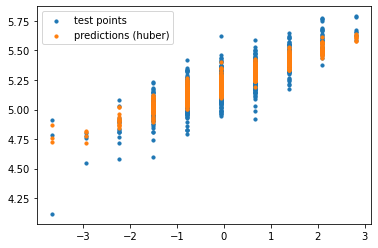

In [60]:
# Same with Huber loss
from sklearn.linear_model import HuberRegressor

# Create the estimator
huber_simple = HuberRegressor(epsilon=1.5)
# Fit it to X,y
huber_simple.fit(X_tr_s_rescaled, y_tr_s)
y_pred_huber_s = huber_simple.predict(X_te_s_rescaled)
mae_huber_s = MAE(10 ** y_te_s, 10 ** y_pred_huber_s)
rmse_s = RMSE(y_te_s, y_pred_huber_s)
print("MAE simple: ${:.2f}".format(mae_huber_s))

# (C) Plot best model
%matplotlib inline
import matplotlib.pyplot as plt

# Plot models
overall_te_s = X_te_s_rescaled[:, 0]  # 1: Overall Quality column
plt.scatter(overall_te_s, y_te_s, s=10, label="test points")
plt.scatter(overall_te_s, y_pred_huber_s, s=10, label="predictions (huber)")
plt.legend()
plt.show()

**E3. Intermediate model**

* For fitting the medium model we will choose the 9 variables that presented a correlation higher than 0.57 with the target variable.

MAE medium: $20118.65


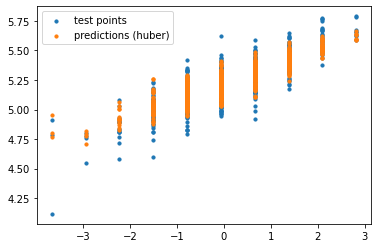

In [61]:
# Same with Huber loss
from sklearn.linear_model import HuberRegressor

# Create the estimator
huber_medium = HuberRegressor(epsilon=1.5)
# Fit it to X,y
huber_medium.fit(X_tr_m_rescaled, y_tr_m)
y_pred_huber_m = huber_medium.predict(X_te_m_rescaled)
mae_huber_m = MAE(10 ** y_te_m, 10 ** y_pred_huber_m)
rmse_m = RMSE(y_te_s, y_pred_huber_m)
print("MAE medium: ${:.2f}".format(mae_huber_m))

# (C) Plot best model
%matplotlib inline
import matplotlib.pyplot as plt

# Plot models
overall_te_m = X_te_m_rescaled[:, 0]  # 1: Overall Quality column
plt.scatter(overall_te_m, y_te_m, s=10, label="test points")
plt.scatter(overall_te_m, y_pred_huber_m, s=10, label="predictions (huber)")
plt.legend()
plt.show()

**E4. Complex model**

* We will finally test the complex model using all of the available variables (Considering the feature engineering that has been made) 

MAE complex: $13261.92


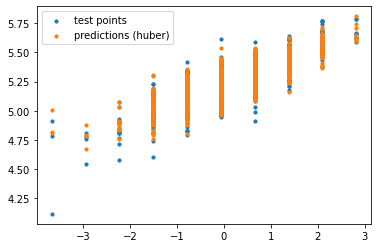

In [62]:
#  Huber loss
from sklearn.linear_model import HuberRegressor

# Create the estimator
huber_complex = HuberRegressor(epsilon=1.05, max_iter=10000)
# Fit it to X,y
huber_complex.fit(X_tr_rescaled, y_tr)
y_pred_huber_c = huber_complex.predict(X_te_rescaled)
mae_huber_c = MAE(10 ** y_te, 10 ** y_pred_huber_c)
rmse_c = RMSE(y_te, y_pred_huber_c)
print("MAE complex: ${:.2f}".format(mae_huber_c))

# (C) Plot best model
%matplotlib inline
import matplotlib.pyplot as plt

# Plot models
overall_te_c = X_te_rescaled[:, index_no]  # 1: Overall Quality column
plt.scatter(overall_te_c, y_te, s=10, label="test points")
plt.scatter(overall_te_c, y_pred_huber_c, s=10, label="predictions (huber)")
plt.legend()
plt.show()

##### [Return to the table of contents](#Table)

<a id="Metrics"></a>
### **F. Evaluation metrics**

**Observations:** In the following lines the different MAE values in dollars are presented. These values come directly from the previous section

In [63]:
print("MAE baseline: ${:.2f}".format(mae_baseline))
print("MAE simple: ${:.2f}".format(mae_huber_s))
print("MAE medium: ${:.2f}".format(mae_huber_m))
print("MAE complex: ${:.2f}".format(mae_huber_c))

MAE baseline: $57287.40
MAE simple: $26467.99
MAE medium: $20118.65
MAE complex: $13261.92


Let's take a look at a simple lr applied to the complex model

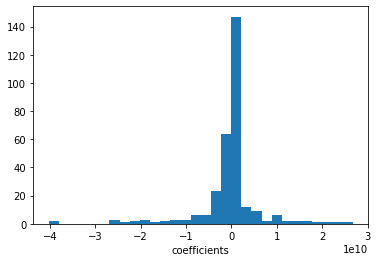

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE

# Try with a linear regression
lr = LinearRegression()
lr.fit(X_tr_rescaled, y_tr)
plt.hist(lr.coef_, bins=30)
plt.xlabel("coefficients")
plt.show()

In [65]:
## Let's calculate the train and validation MSE value (which is associated to the error)
print("Train MSE: {:.4f}".format(MSE(y_tr, lr.predict(X_tr_rescaled))))
print("Validation MSE: {:.4f}".format(MSE(y_te, lr.predict(X_te_rescaled))))

Train MSE: 0.0016
Validation MSE: 1096404666541269188608.0000


**Observation** Note the 1e10 factor on the x-axis. The high validation score probably comes from numerical issues due to those large coefficients. Its precisely for solving problems like this one that we use regularization. We will try to tune the regularization strength for finding a stable solution. For making this posible we will iterate over a list of alphas and pick the one with the best validation score.

##### [Return to the table of contents](#Table)

<a id="Regularization"></a>
### **G. Regularization**

* The regularization is the process through wich the overfitting and underfitting of the models is adjusted. By regularization we may opt for simpler models as complex models usually don't generalize well on the unseen data. In the following section we will do the regularization of the complex model that we previously presented. We will be using the strategy of grid search. 

**Regularization of the Complex model** 

In [66]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as RMSE

# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-4, 8, num=50):
    # Create and fit ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr_rescaled, y_tr)

    # Save model and its performance on train/validation sets
    gs_results.append(
        {
            "alpha": alpha,
            "train_mse": MSE(y_tr, ridge.predict(X_tr_rescaled)),
            "train_rmse": RMSE(y_tr, ridge.predict(X_tr_rescaled)),
            "train_mae": MAE(10 ** y_tr, 10 ** ridge.predict(X_tr_rescaled)),
            "validation_mse": MSE(y_te, ridge.predict(X_te_rescaled)),
            "validation_rmse": RMSE(y_te, ridge.predict(X_te_rescaled)),
            "validation_mae": MAE(10 ** y_te, 10 ** ridge.predict(X_te_rescaled)),
        }
    )

In [67]:
# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,train_mse,train_rmse,train_mae,validation_mse,validation_rmse,validation_mae
0,0.000100,0.001568,0.001568,10490.594740,0.002775,0.002775,13299.896669
1,0.000176,0.001572,0.001572,10497.586287,0.002777,0.002777,13280.322606
2,0.000309,0.001576,0.001576,10512.570587,0.002783,0.002783,13268.028542
3,0.000543,0.001582,0.001582,10533.800592,0.002790,0.002790,13262.488951
4,0.000954,0.001589,0.001589,10560.562835,0.002797,0.002797,13250.320491


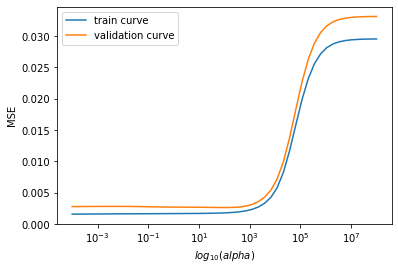

In [68]:
# Plot the validation curves
plt.semilogx(gs_results["alpha"], gs_results["train_mse"], label="train curve")
plt.semilogx(
    gs_results["alpha"], gs_results["validation_mse"], label="validation curve"
)
plt.xlabel("$log_{10}(alpha)$")
plt.ylabel("MSE")
plt.legend()
plt.show()

**Observations:** 

* The optimal alpha value is around 10e2
* The model starts overfitting when alpha is smaller than 10e1
* The models starts underfitting when alpha is larger than 10e4
* It’s also interesting to see that the validation score reaches a plateau with alpha values between 10e5 and 10e6. This is the effect of regularization: when the regularization strength is too large, the model coefficient goes to zero and the model always predicts the intercept term.

In [69]:
# Get entry with the best validation MSE
best_result = gs_results.loc[gs_results.validation_mse.idxmin()]
best_result = gs_results.loc[gs_results.validation_rmse.idxmin()]
mae_complex_reg = format(best_result.validation_mae)
# Print the details
print("Best alpha: {:.1e}".format(best_result.alpha))
print("Validation MSE: {:.4f}".format(best_result.validation_mse))
print("Validation MAE: {:,.0f}$".format(best_result.validation_mae))
print("Validation RMSE: {:,.4f}".format(best_result.validation_rmse))

Best alpha: 7.5e+01
Validation MSE: 0.0026
Validation MAE: 13,192$
Validation RMSE: 0.0026


In [70]:
# Create and fit the best ridge regression
# Variable to store the results
gs_best = []
ridge_complex = Ridge(alpha=(best_result.alpha))
ridge_complex.fit(X_tr_rescaled, y_tr)

# Save model and its performance on train/validation sets
gs_best.append(
    {
        "train_mse": MSE(y_tr, ridge_complex.predict(X_tr_rescaled)),
        "train_mae": MAE(10 ** y_tr, 10 ** ridge_complex.predict(X_tr_rescaled)),
        "validation_mse": MSE(y_te, ridge_complex.predict(X_te_rescaled)),
        "validation_mae": MAE(10 ** y_te, 10 ** ridge_complex.predict(X_te_rescaled)),
    }
)
gs_best

[{'train_mse': 0.0017440282001760284,
  'train_mae': 11070.707756831198,
  'validation_mse': 0.0026205205887488733,
  'validation_mae': 13191.65687701744}]

**Observations**  We may see that the previous problem of the model, evidenced in the high test_mae value has been appropriately corrected with the incorporation of the regularization

##### [Return to the table of contents](#Table)

<a id="Communicate"></a>
### **H. Communicating the results**

* For the following point we will compare the MAE and RMSE results of all of the models that were tried (baseline, simple, medium, complex and regularized complex)

**Observation** If we analyze the MAE we may see that the simple and medium models do not present a big difference in terms of the estimation (in dollars),but they are far from the complex models, wich do not present big differences between the regularized and unregularized version. Let's take a further look using the RMSE error predictor

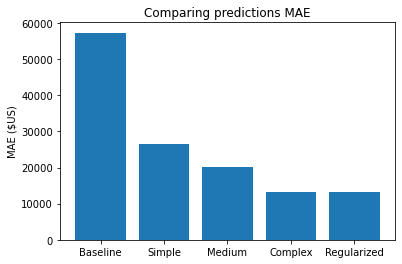

In [71]:
# MAE Comparison
mae_values = [
    mae_baseline,
    mae_huber_s,
    mae_huber_m,
    mae_huber_c,
    (best_result.validation_mae),
]
titles = [
    "Baseline",
    "Simple",
    "Medium",
    "Complex",
    "Regularized",
]

plt.bar(titles, mae_values)
plt.title("Comparing predictions MAE")
plt.ylabel("MAE ($US)")
plt.show()

**Observation:** The difference between the performance of the recularized and not regularized complex model is much clearer when comparing the RMSE prediction errors. We may see that the best model is by far the regularized complex version

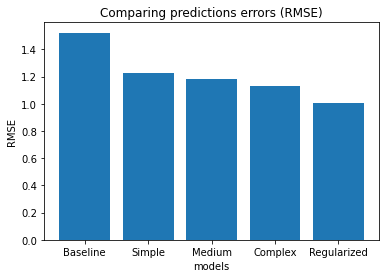

In [72]:
# RMSE Comparison
# Bar chart
plt.bar(
    [1, 2, 3, 4, 5],
    [
        10 ** rmse_baseline,
        10 ** rmse_s,
        10 ** rmse_m,
        10 ** rmse_c,
        10 ** (best_result.validation_rmse),
    ],
)
plt.xticks([1, 2, 3, 4, 5], ["Baseline", "Simple", "Medium", "Complex", "Regularized"])
plt.title("Comparing predictions errors (RMSE)")
plt.xlabel("models")

plt.ylabel("RMSE")
plt.show()

With this information we will now compute the predictions for finally evaluating them

##### [Return to the table of contents](#Table)

<a id="Compute"></a>
### **I. Compute Predictions**

* It is important to understand that for trying the test data, we must have the information in the same format that we have the data that was used for training the models. Hence, we will make a quick preparation of the test data for then adjusting the models that we prepared with the training. Let's consider that we already discussed the data cleaning and feature engineering processes; therefore, we will just include the steps without further explanations

**Data preparation (cleaning and feature engineering)**

In [73]:
# Load the test data

data_df = pd.read_csv("house-prices-test.csv")

In [74]:
# We fill the NaN values of the columns saved in unique. For filling this columns, there is an only value that may be incorporated (as it was previously stated)

data_df.drop(["Central Air"], axis=1, inplace=True)
data_df.drop(["Street"], axis=1, inplace=True)
data_df.drop(["Order"], inplace=True, axis=1)
# We calculate the null percentage:
null_percentage = data_df.isnull().sum() / data_df.shape[0] * 100
# Drop columns with more than a 40% of missing values
for x in range(0, len(null_percentage)):
    if null_percentage[x] >= 40:
        data_df.drop([null_percentage.index[x]], axis=1, inplace=True)

In [75]:
# Drop columns and replace or drop NaN values

null_list = data_df.columns[data_df.isnull().any()].tolist()

# Replace numerical NaN values

# Mean replacements (near to normal distributions)
data_df["Lot Frontage"].fillna(int(data_df["Lot Frontage"].mean()), inplace=True)
data_df["Total Bsmt SF"].fillna(int(data_df["Total Bsmt SF"].mean()), inplace=True)
data_df["Garage Area"].fillna(int(data_df["Garage Area"].mean()), inplace=True)
# Median replacements (skewed distributions)
data_df["Garage Yr Blt"].fillna(int(data_df["Garage Yr Blt"].median()), inplace=True)
data_df["Mas Vnr Area"].fillna(int(data_df["Mas Vnr Area"].median()), inplace=True)
data_df["Bsmt Unf SF"].fillna(int(data_df["Bsmt Unf SF"].median()), inplace=True)
data_df["BsmtFin SF 1"].fillna(int(data_df["BsmtFin SF 1"].median()), inplace=True)
data_df["Bsmt Half Bath"].fillna(int(data_df["Bsmt Half Bath"].median()), inplace=True)
data_df["Bsmt Full Bath"].fillna(int(data_df["Bsmt Full Bath"].median()), inplace=True)
data_df["Garage Cars"].fillna(int(data_df["Garage Cars"].median()), inplace=True)
# Fill categorical features with a new missing category
data_df["Bsmt Qual"].fillna(("Missing"), inplace=True)
data_df["BsmtFin Type 1"].fillna(("Missing"), inplace=True)
data_df["Garage Finish"].fillna(("Missing"), inplace=True)
data_df = data_df.fillna(data_df.mode().iloc[0])

In [76]:
# Convert ordinal to numeric features
nominal = []
ordinal = []
# check line by line in txt
with open("documentation.txt", "rt") as f:
    data = f.readlines()
# Generate two lists for Nominal and Ordinal variables
for line in data:
    if "(Nominal)" in line:
        nominal.append(line)

    if "(Ordinal)" in line:
        ordinal.append(line)

# Auxiliar variables for searching in the list of names
sub_str_nom = "(Nominal):"
sub_str_ord = "(Ordinal)"

# Remove after substring in String
nominal_var = []
ordinal_var = []
# slicing nominal variables names
for test_str in nominal:
    res = test_str[: test_str.index(sub_str_nom)][:-1]
    nominal_var.append(res)
# slicing ordinal variables names
for test_str in ordinal:
    res1 = test_str[: test_str.index(sub_str_ord)][:-1]
    ordinal_var.append(res1)

# Remove variables that have been already dropped in the original df
nominal_var.remove("Alley")
nominal_var.remove("Misc Feature")
nominal_var.remove("Street")
nominal_var.remove("Central Air")

# Replace inexact names in .txt
nominal_var.remove("Exterior 1")
nominal_var.append("Exterior 1st")
nominal_var.remove("Exterior 2")
nominal_var.append("Exterior 2nd")

# Replace inexact names in .txt
ordinal_var.remove("BsmtFinType 2")
ordinal_var.append("BsmtFin Type 2")
ordinal_var.remove("HeatingQC")
ordinal_var.append("Heating QC")
ordinal_var.remove("KitchenQual")
ordinal_var.append("Kitchen Qual")
ordinal_var.remove("FireplaceQu")
# Remove variables that have been already dropped in the original df
ordinal_var.remove("Fence")
ordinal_var.remove("Pool QC")

# Replace strings with numbers
data_df[ordinal_var] = data_df[ordinal_var].replace(
    to_replace=["Reg", "IR1", "IR2", "IR3"], value=[4, 3, 2, 1]
)
data_df[ordinal_var] = data_df[ordinal_var].replace(
    to_replace=["AllPub", "NoSewr", "NoSeWa", "ELO"], value=[4, 3, 2, 1]
)
data_df[ordinal_var] = data_df[ordinal_var].replace(
    to_replace=["Gtl", "Mod", "Sev"], value=[3, 2, 1]
)

data_df[ordinal_var] = data_df[ordinal_var].replace(
    to_replace=["Ex", "Gd", "TA", "Fa", "Po", "NA"], value=[5, 4, 3, 2, 1, 0]
)
data_df[ordinal_var] = data_df[ordinal_var].replace(
    to_replace=["Av", "Mn", "No"], value=[3, 2, 1]
)
data_df[ordinal_var] = data_df[ordinal_var].replace(
    to_replace=["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf"], value=[6, 5, 4, 3, 2, 1]
)
data_df[ordinal_var] = data_df[ordinal_var].replace(
    to_replace=["SBrkr", "FuseA", "FuseF", "FuseP", "Mix"], value=[5, 4, 3, 2, 1]
)
data_df[ordinal_var] = data_df[ordinal_var].replace(
    to_replace=["Typ", "Min1", "Min2", "Mod", "Maj1", "Maj2", "Sev", "Sal"],
    value=[8, 7, 6, 5, 4, 3, 2, 1],
)

data_df[ordinal_var] = data_df[ordinal_var].replace(
    to_replace=["Fin", "RFn"], value=[3, 2]
)
data_df[ordinal_var] = data_df[ordinal_var].replace(
    to_replace=["Y", "P", "N"], value=[3, 2, 1]
)
data_df[ordinal_var] = data_df[ordinal_var].replace(
    to_replace=["GdPrv", "MnPrv", "GdWo", "MnWw"], value=[4, 3, 2, 1]
)
# Missing values are also replaced with 0
data_df[ordinal_var] = data_df[ordinal_var].replace(to_replace="Missing", value=0)

In [77]:
# We finally change MS SubClass (the numeric variable) to a non numerical version for the hot-encoding.
data_df["MS SubClass"] = data_df["MS SubClass"].map(str)
pd.value_counts(data_df[nominal_var].dtypes)

object    19
int64      1
dtype: int64

In [78]:
# Add boolean variables
data_df["Has Mas Vnr"] = data_df["Mas Vnr Area"].apply(lambda x: 1 if x > 0 else 0)
data_df["Has Basement"] = data_df["Total Bsmt SF"].apply(lambda x: 1 if x > 0 else 0)
data_df["Has 2ndFloor"] = data_df["2nd Flr SF"].apply(lambda x: 1 if x > 0 else 0)
data_df["Has Garage"] = data_df["Garage Area"].apply(lambda x: 1 if x > 0 else 0)
data_df["Has WoodDeck"] = data_df["Wood Deck SF"].apply(lambda x: 1 if x > 0 else 0)
data_df["Has Porch"] = data_df["Open Porch SF"].apply(lambda x: 1 if x > 0 else 0)

In [79]:
# data_df.drop("Total Bsmt SF", inplace=True, axis=1)
# data_df.drop("Exter Qual", inplace=True, axis=1)
# data_df.drop("Garage Yr Blt", inplace=True, axis=1)
# data_df.drop("Garage Area", inplace=True, axis=1)
data_df["New"] = np.where(data_df["Yr Sold"] == data_df["Year Built"], 1, 0)

In [80]:
# Add Bath variable
data_df["Bath"] = (
    data_df["Full Bath"]
    + (0.5 * data_df["Half Bath"])
    + data_df["Bsmt Full Bath"]
    + (0.5 * data_df["Bsmt Half Bath"])
)

data_df.drop("Full Bath", inplace=True, axis=1)
data_df.drop("Half Bath", inplace=True, axis=1)
data_df.drop("Bsmt Full Bath", inplace=True, axis=1)
data_df.drop("Bsmt Half Bath", inplace=True, axis=1)

In [81]:
continuous = [
    "Total Bsmt SF",
    "Lot Frontage",
    "Lot Area",
    "Mas Vnr Area",
    "BsmtFin SF 1",
    "BsmtFin SF 2",
    "Bsmt Unf SF",
    "1st Flr SF",
    "2nd Flr SF",
    "Low Qual Fin SF",
    "Gr Liv Area",
    "Wood Deck SF",
    "Open Porch SF",
    "Enclosed Porch",
    "3Ssn Porch",
    "Garage Area",
    "Screen Porch",
    "Pool Area",
    "Misc Val",
]

**Observations:** As we have to maintain the 500 rows for doing the predictions we did not include outlier cleaning (this was reducing the number of rows).

* There are some values in the hot-encoding that are found in the original database, but may not be found in the test. For avoiding problems with size when transforming and predicting the variables we will:
 - Drop the columns that are not present in train, but that are present in test. 
 - Add to test every feature that is not present in test but present in train will be added to test with a column of zeros.
Doing this should not affect the model prediction.

In [82]:
# Remove columns that test does not have
preprocessed_test_df = preprocess(data_df)
train_columns = preprocessed_df.columns.tolist()
test_columns = preprocessed_test_df.columns.tolist()

train_not_test = set(train_columns).difference(test_columns)
print(train_not_test)
for c in train_not_test:
    preprocessed_test_df[c] = 0

test_not_train = set(test_columns).difference(train_columns)
print(test_not_train)
preprocessed_test_df.drop(columns=test_not_train, inplace=True)
preprocessed_test_df

{'MS Zoning_I (all)', 'Condition 2_RRAn', 'Condition 2_PosA', 'Exterior 1st_Stone', 'Roof Matl_Metal', 'Exterior 1st_ImStucc', 'Exterior 2nd_PreCast', 'Foundation_Wood', 'SalePrice', 'Sale Type_Con', 'Exterior 1st_CBlock', 'Roof Style_Shed', 'Roof Matl_WdShngl', 'Exterior 2nd_AsphShn', 'Roof Matl_Membran', 'Exterior 1st_BrkComm', 'Heating_Floor', 'Condition 2_RRNn', 'Neighborhood_Landmrk', 'Neighborhood_GrnHill', 'Exterior 1st_PreCast', 'Condition 2_Artery', 'Exterior 1st_AsphShn', 'Sale Type_VWD', 'Neighborhood_Greens', 'Mas Vnr Type_CBlock', 'MS Zoning_A (agr)'}
{'Exterior 2nd_Other', 'Roof Matl_Roll'}


,PID,Lot Frontage,Lot Area,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Year Built,Year Remod/Add,...,Condition 2_RRNn,Neighborhood_Landmrk,Neighborhood_GrnHill,Exterior 1st_PreCast,Condition 2_Artery,Exterior 1st_AsphShn,Sale Type_VWD,Neighborhood_Greens,Mas Vnr Type_CBlock,MS Zoning_A (agr)
0,909279080,4.248495,9.330432,3,4,2,6,7,1932,1950,...,0,0,0,0,0,0,0,0,0,0
1,907126050,4.189655,9.185843,4,4,2,5,7,1994,1994,...,0,0,0,0,0,0,0,0,0,0
2,528144030,4.465908,9.311633,3,4,3,8,5,2006,2006,...,0,0,0,0,0,0,0,0,0,0
3,535452060,4.262680,8.853808,4,4,3,5,7,1960,2002,...,0,0,0,0,0,0,0,0,0,0
4,911202100,4.204693,9.072571,4,4,2,4,7,1900,1950,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,905378040,4.828314,9.830971,4,4,3,3,4,1938,1990,...,0,0,0,0,0,0,0,0,0,0
496,533252020,4.248495,9.328212,3,4,3,6,6,1977,1977,...,0,0,0,0,0,0,0,0,0,0
497,527127100,3.367296,8.895219,3,4,3,8,5,2004,2005,...,0,0,0,0,0,0,0,0,0,0
498,906340120,4.127134,9.232787,3,4,3,8,5,2008,2008,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# order columns alphabetically (for having consistency with the order of the trained model)
preprocessed_test_df = preprocessed_test_df.reindex(
    sorted(preprocessed_test_df.columns), axis=1
)
# Don't forget to drop the created value SalePrice (it was accidentally created with the index iteration of the last step)
preprocessed_test_df.drop("SalePrice", inplace=True, axis=1)

In [84]:
# X test variables and standardization
X_te_s = preprocessed_test_df[simple].values
X_te_m = preprocessed_test_df[medium].values
X_te_c = preprocessed_test_df.values

# Standardize features
scaler_simple = StandardScaler()
X_te_s_rescaled = scaler_simple.fit_transform(X_te_s)

# Standardize features
scaler_med = StandardScaler()
X_te_m_rescaled = scaler_med.fit_transform(X_te_m)

# Standardize features
scaler_complex = StandardScaler()
X_te_c_rescaled = scaler_complex.fit_transform(X_te_c)

**Predictions from your simple model - predictions-simple-model.csv**

In [85]:
# Create the estimator
y_pred_huber_s = huber_simple.predict(X_te_s_rescaled)

df_simple = pd.DataFrame(data_df["PID"])
df_simple["SalePrice"] = 10 ** y_pred_huber_s
df_simple.to_csv("predictions-simple-model.csv", index=False)

**Predictions from your intermediate model - predictions-intermediate-model.csv**

In [86]:
y_pred_huber_m = huber_medium.predict(X_te_m_rescaled)

df_medium = pd.DataFrame(data_df["PID"])
df_medium["SalePrice"] = 10 ** (y_pred_huber_m)
df_medium.to_csv("predictions-intermediate-model.csv", index=False)

**Predictions from your complex model - predictions-complex-model.csv**

In [87]:
y_ridge_pred_c = ridge_complex.predict(X_te_c_rescaled)

df_complex = pd.DataFrame(data_df["PID"])
df_complex["SalePrice"] = 10 ** (y_ridge_pred_c)
df_complex.to_csv("predictions-complex-model.csv", index=False)

##### [Return to the table of contents](#Table)

<a id="Evaluate"></a>
### **J. Evaluate Predictions**

**Observations:** The predictions and performances were checked as suggested by the last point. The results are consistent with the results that were discussed in the previous points. Hence, the complex regularized model presents the highest potential for predicting the SalePrice, considering a best MAE and RSME values. It is important to consider that the obtained values are very similar to the ones obtained in the model training sections for the MAE; however, the RMSE values contain higher differences, even though the complex model still shows better results

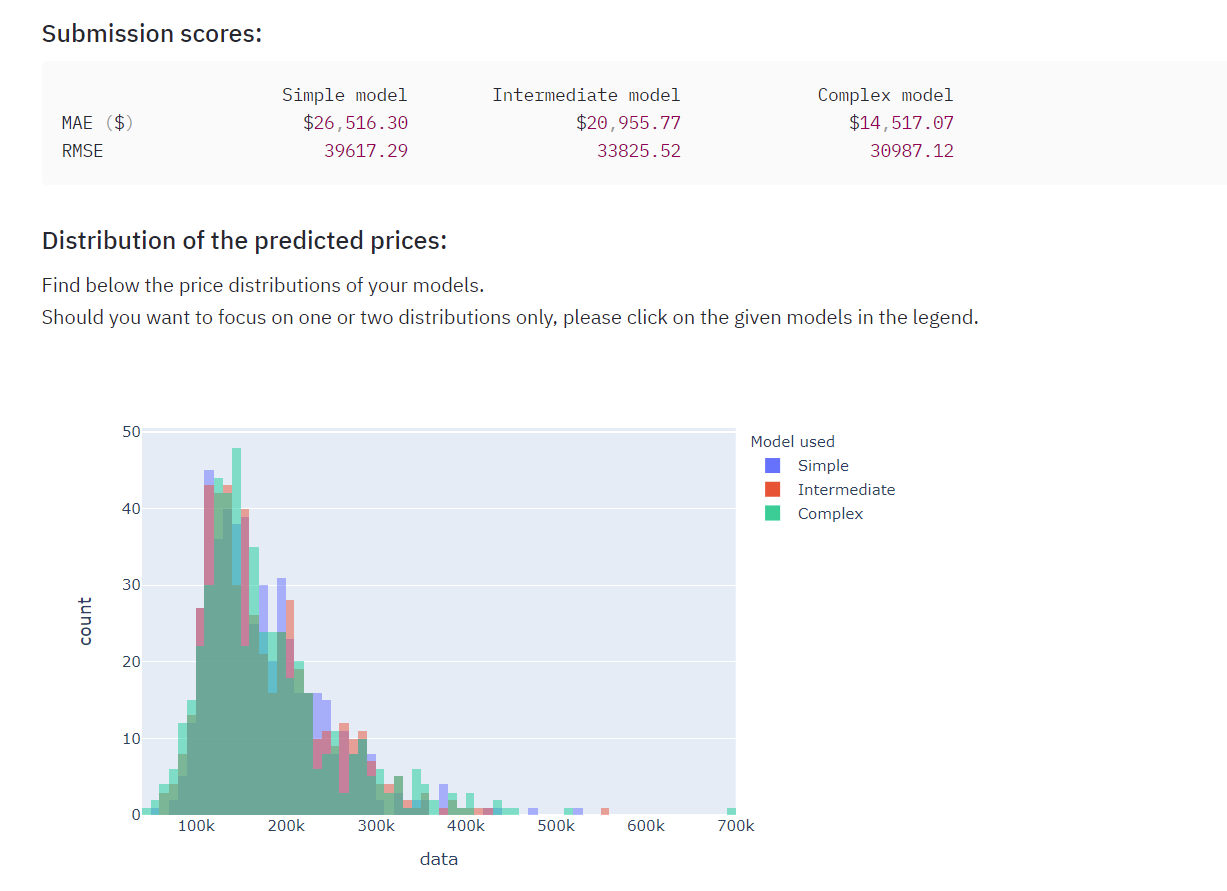

In [88]:
from IPython.display import Image

Image(filename="submission_scores.png")

##### [Return to the table of contents](#Table)